#Extraindo os dados que vão ser trabalhados

Primeiramente, precisamos importas as bibliotecas do pandas para manipular dataframes e networkx para criar os grafos a partir de dataframes.

In [0]:
import pandas as pd
import networkx as nx

Conseguimos um arquivo .csv com os dados dos jogos de campeonatos de League of Legends de 2014 a 2018. Colocamos no drive e lemos com o pandas para gerar essa informação dataframe.

In [0]:
lol_data = pd.read_csv("https://drive.google.com/uc?authuser=0&id=18s-wCIJi4wxFQVawJezIx86M2lWVps3j&export=download")

In [3]:
#anos de campeonatos de lol
lol_data.Year.unique()

array([2015, 2016, 2017, 2014, 2018])

In [4]:
lol_data.head()

League  ...                                            Address
0  NALCS  ...  http://matchhistory.na.leagueoflegends.com/en/...
1  NALCS  ...  http://matchhistory.na.leagueoflegends.com/en/...
2  NALCS  ...  http://matchhistory.na.leagueoflegends.com/en/...
3  NALCS  ...  http://matchhistory.na.leagueoflegends.com/en/...
4  NALCS  ...  http://matchhistory.na.leagueoflegends.com/en/...

[5 rows x 30 columns]

Como pode ser visto cada linha refere-se a um jogo de um dos campeonatos (League), em uma determinada temporada (Season) de um ano especifico (Year). Em que o resultado dividi-se em 1 para quem venceu e 0 para quem perdeu seja do time azul (bResult) ou vermelho (rResult).

In [5]:
lol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620 entries, 0 to 7619
Data columns (total 30 columns):
League              7620 non-null object
Year                7620 non-null int64
Season              7620 non-null object
Type                7620 non-null object
blueTeamTag         7582 non-null object
bResult             7620 non-null int64
rResult             7620 non-null int64
redTeamTag          7583 non-null object
gamelength          7620 non-null int64
blueTop             7583 non-null object
blueTopChamp        7620 non-null object
blueJungle          7592 non-null object
blueJungleChamp     7620 non-null object
blueMiddle          7583 non-null object
blueMiddleChamp     7620 non-null object
blueADC             7583 non-null object
blueADCChamp        7620 non-null object
blueSupport         7583 non-null object
blueSupportChamp    7620 non-null object
redTop              7583 non-null object
redTopChamp         7620 non-null object
redJungle           7596 non-null ob

Como cada linha representa um jogo, criamos uma coluna GameID para guardar esses valores, visto que agora precisamos alinhar em cada linha o jogo e o resultado para cada time, ou seja, é preciso ter em uma linha os jogadores do time vermelho, qual foi o jogo (GameID) e que resultado tiveram na partida (rResult), assim como do time azul. Assim, separamos e emseguida concatemos, dobrando o numero de linahs do nosso dataframe.

In [0]:
#cada id representa o jogo analisado
lol_data["GameID"] = lol_data.index

In [7]:
lolb = lol_data[["GameID","League","Year","bResult","blueTopChamp","blueJungleChamp","blueMiddleChamp","blueADCChamp","blueSupportChamp"]]
lolr = lol_data[["GameID","League","Year","rResult","redTopChamp","redJungleChamp","redMiddleChamp","redADCChamp","redSupportChamp"]]
lolr.columns = ["GameID","League","Year","Result","TopChamp","JungleChamp","MiddleChamp","ADCChamp","SupportChamp"]
lolb.columns = ["GameID","League","Year","Result","TopChamp","JungleChamp","MiddleChamp","ADCChamp","SupportChamp"]
lolb["GameID"] = lolb["GameID"].astype(str)
lolb["GameID"] = lolb["GameID"]+"b"
lolr["GameID"] = lolr["GameID"].astype(str)
lolr["GameID"] = lolr["GameID"]+"r"
lol = pd.concat([lolb,lolr], ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [8]:
lol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15240 entries, 0 to 15239
Data columns (total 9 columns):
GameID          15240 non-null object
League          15240 non-null object
Year            15240 non-null int64
Result          15240 non-null int64
TopChamp        15240 non-null object
JungleChamp     15240 non-null object
MiddleChamp     15240 non-null object
ADCChamp        15240 non-null object
SupportChamp    15240 non-null object
dtypes: int64(2), object(7)
memory usage: 1.0+ MB


No dataframe original uma vitória vale 1 e uma derrota vale 0, entretanto para nossa análise de melhores jogadores levamos em conta o numero de derrotas, e assim, substituimos o 0 por -1, para que na soma que faremos adiante, uma derrota anule uma vitória do personagem no jogo.

In [9]:
#aqui definimos que uma derrota de um time anula uma vitoria
lol["Result"].replace(0, -1,inplace = True)
lol.head()

GameID League  Year  Result  ... JungleChamp MiddleChamp  ADCChamp SupportChamp
0     0b  NALCS  2015       1  ...      RekSai        Ahri      Jinx        Janna
1     1b  NALCS  2015      -1  ...      Rengar        Ahri   Caitlyn        Leona
2     2b  NALCS  2015       1  ...      Rengar        Fizz     Sivir        Annie
3     3b  NALCS  2015      -1  ...    JarvanIV     Leblanc     Sivir       Thresh
4     4b  NALCS  2015       1  ...    JarvanIV   Lissandra  Tristana        Janna

[5 rows x 9 columns]

Agora, vamos dividir os dataframes por ligas(campeonatos) e escolhemos estudar o comportamento dos jogos que ocorreram em 2017 por que ao analisarmos percebemos que tinham dados mais consistentes e mais próximos do presente ano.

In [0]:
#dividindo o dataset em campeonatos de todos os anos e seasons
lol = lol.loc[lol["Year"] == 2017]
NALCS = lol.loc[lol["League"] == "NALCS"]
EULCS = lol.loc[lol["League"] == "EULCS"]
WC = lol.loc[lol["League"] == "WC"]
CBLOL = lol.loc[lol["League"] == "CBLoL"]
MSI = lol.loc[lol["League"] == "MSI"]
LCK = lol.loc[lol["League"] == "LCK"]

Após esse corte, temos as seguintes quantidades de jogos para estudarmos.

In [11]:
#numero de jogos de cada campeonato
print(NALCS.shape[0],EULCS.shape[0],WC.shape[0],MSI.shape[0],CBLOL.shape[0],LCK.shape[0],)

1082 804 160 84 272 1010


Agora definimos uma função que separa cada jogador de cada time em uma linha com seu respectivo Line e Result para podermos analisarmos cada um.

In [0]:
def set_champions(df):
    frame = { 'Champion': df["SupportChamp"], 'GameID': df["GameID"], "Result": df["Result"], "Line" : "Support"} 
    supportb= pd.DataFrame(frame)
    frame = { 'Champion': df["ADCChamp"], 'GameID': df["GameID"], "Result": df["Result"], "Line" : "ADC" } 
    ADCb= pd.DataFrame(frame)
    frame = { 'Champion': df["MiddleChamp"], 'GameID': df["GameID"], "Result": df["Result"], "Line" : "Middle" } 
    Middleb= pd.DataFrame(frame)
    frame = { 'Champion': df["JungleChamp"], 'GameID': df["GameID"], "Result": df["Result"], "Line" : "Jungle" } 
    Jungleb= pd.DataFrame(frame)
    frame = { 'Champion': df["TopChamp"], 'GameID': df["GameID"], "Result": df["Result"], "Line" : "Top" } 
    Topb= pd.DataFrame(frame)
    return pd.concat([supportb, ADCb,Middleb,Jungleb,Topb], ignore_index=True)


NALCS_champions = set_champions(NALCS)
EULCS_champions = set_champions(EULCS)
WC_champions = set_champions(WC)
CBLOL_champions = set_champions(CBLOL)
MSI_champions = set_champions(MSI)
LCK_champions = set_champions(LCK)

In [13]:
WC_champions.head()

Champion GameID  Result     Line
0    Janna  6618b       1  Support
1     Lulu  6619b      -1  Support
2     Lulu  6620b      -1  Support
3    Janna  6621b      -1  Support
4     Lulu  6622b       1  Support

#Configurando os dataframes

Com os dataframes definidos passamos a implemetar funções que extraiam as informações que precisamos para encontrar o melhor time.  Precisamos saber a quantidade de vitorias de cada champion, e liga-los uns aos outros de acordo com o jogo que partipam juntos. Ou seja, cada time (blue e red) possuem ligações entre os champions e um resultado de vitoria atrelado a essa ligação.

Primeiramente, faremos a contagem de vitorias de cada personagem, e para definirmos que line ele teve maior desempenho, somamos suas vitorias de acordo com a line que ele atuou no jogo. Senod que a maior pontuação define a line que o jogador é mais forte.

In [0]:
#contando numeros de vitorias por champions em cada line
def total_victories(data):
  champions =  data.Champion.unique()
  dict_wins = {}
  
  for champion in champions:
    lines = data.loc[data["Champion"] == champion]["Line"].unique()
    dict_wins[champion] = {}
    for line in lines:
      dict_wins[champion][line] = data.loc[(data['Champion'] == champion) & (data["Line"] == line)].Result.sum()
  return dict_wins
 
all_datas_list = []
#NALCS
data_nalcs = pd.DataFrame(total_victories(NALCS_champions))
#tranposição de colunas para linhas
data_nalcs = data_nalcs.T

all_datas_list.append(data_nalcs)

#EULCS
data_eulcs = pd.DataFrame(total_victories(EULCS_champions))
#tranposição de colunas para linhas
data_eulcs = data_eulcs.T

all_datas_list.append(data_eulcs)

#WC
data_wc = pd.DataFrame(total_victories(WC_champions))
#tranposição de colunas para linhas
data_wc = data_wc.T

all_datas_list.append(data_wc)


#CBLOS
data_cblol = pd.DataFrame(total_victories(CBLOL_champions))
#tranposição de colunas para linhas
data_cblol = data_cblol.T

all_datas_list.append(data_cblol)

#MSI
data_msi = pd.DataFrame(total_victories(MSI_champions))
#tranposição de colunas para linhas
data_msi = data_msi.T

all_datas_list.append(data_msi)

#MSI
data_lck = pd.DataFrame(total_victories(LCK_champions))
#tranposição de colunas para linhas
data_lck = data_lck.T

all_datas_list.append(data_lck)


In [15]:
data_lck.head()

ADC  Jungle  Middle  Support  Top
Malzahar     NaN     NaN     4.0      5.0  NaN
TahmKench    NaN     NaN     NaN     -8.0  NaN
MissFortune -1.0     NaN     NaN     -2.0  NaN
Zyra         NaN     NaN     NaN     23.0  NaN
Karma        NaN     NaN     0.0    -14.0  NaN

Acima podemos ver que Malzahar, por exemplo, somando vitorias e derrotas por cada line em que participou nos jogos dessa liga, é mais forte como Support do que Middle, mas esse personagem possui um saldo de 9 pontos de vitorias. 


Assim, a função a seguir além de tornar positivos todos os valores de pontuação (somando a cada valor o valor minimo encontrado) define o line do personagem, de acordo com o que foi dito anteriromente, e qual a pontuação total de vitorias daquele personagem.

In [0]:
#deixando todos valores positivos, execeto NaN
def positive_values(data):
  menor_score = -min([data.ADC.min(), data.Jungle.min(), data.Middle.min(), data.Support.min(), data.Top.min()])
  data += menor_score
  #definindo o papel principal de acordo com o numero de vitorias
  data['main_line'] = data.idxmax(axis=1)
  data['total'] = data.ADC.fillna(0) + data.Jungle.fillna(0) + data.Middle.fillna(0) + data.Support.fillna(0) + data.Top.fillna(0)  
  #setando NaN com -1 para na visualiação eliminar nó menor que 0
  data.fillna(-1, inplace=True)
  
for data in all_datas_list:
  positive_values(data)

A seguir mostramos que em cada dataframe temos represnetantes de todos os lines possiveis.

In [17]:
for data in all_datas_list:
  print(data.main_line.unique())

['Support' 'Middle' 'Top' 'Jungle' 'ADC']
['Middle' 'Support' 'ADC' 'Jungle' 'Top']
['Support' 'Middle' 'ADC' 'Top' 'Jungle']
['Support' 'Top' 'Middle' 'Jungle' 'ADC']
['Support' 'ADC' 'Middle' 'Top' 'Jungle']
['Support' 'ADC' 'Middle' 'Top' 'Jungle']


Agora, temos um dataframe que define bem cada personagem, ou seja, os nós do nossos grafos.

In [18]:
for data in all_datas_list:
  data.columns = data.columns.str.lower()
  print(data.head())

           adc  jungle  middle  support  top main_line  total
Zyra      -1.0    -1.0    -1.0      0.0 -1.0   Support    0.0
Taric     -1.0    -1.0    -1.0     36.0 -1.0   Support   36.0
TahmKench -1.0    -1.0    -1.0     34.0 -1.0   Support   34.0
Karma     -1.0    -1.0    28.0     24.0 -1.0    Middle   52.0
Malzahar  -1.0    -1.0    26.0     24.0 -1.0    Middle   50.0
              adc  jungle  middle  support  top main_line  total
Karma        -1.0    -1.0    18.0     16.0 -1.0    Middle   34.0
Zyra         -1.0    -1.0    -1.0     19.0 -1.0   Support   19.0
MissFortune  18.0    -1.0    -1.0     16.0 -1.0       ADC   34.0
Thresh       18.0    -1.0    -1.0     18.0 -1.0       ADC   36.0
Malzahar     -1.0    -1.0    19.0     34.0 -1.0   Support   53.0
        adc  jungle  middle  support  top main_line  total
Janna  -1.0    -1.0    -1.0     29.0 -1.0   Support   29.0
Lulu   -1.0    -1.0    -1.0      2.0 -1.0   Support    2.0
Karma  -1.0    -1.0    10.0      7.0 -1.0    Middle   17.0
Ra

E com o dataframe a seguir iremos definir organizar nossas arestas, pois como ja foi dito os champions estão ligados entre os demais champions do seu time em cada jogo.

In [0]:
#todas colunas em lowercase
LCK_champions.columns = LCK_champions.columns.str.lower()
NALCS_champions.columns = NALCS_champions.columns.str.lower()
EULCS_champions.columns = EULCS_champions.columns.str.lower()
WC_champions.columns = WC_champions.columns.str.lower()
CBLOL_champions.columns = CBLOL_champions.columns.str.lower()
MSI_champions.columns = MSI_champions.columns.str.lower()

In [20]:
#cada jogo tem dois times, um vencedor e outro perdedor
WC_champions.loc[WC_champions['gameid'] == '6618b']

champion gameid  result     line
0         Janna  6618b       1  Support
160      KogMaw  6618b       1      ADC
320  Cassiopeia  6618b       1   Middle
480    JarvanIV  6618b       1   Jungle
640      Maokai  6618b       1      Top

In [21]:
WC_champions.loc[WC_champions['gameid'] == '6618r']

champion gameid  result     line
80       Lulu  6618r      -1  Support
240  Tristana  6618r      -1      ADC
400      Ryze  6618r      -1   Middle
560    RekSai  6618r      -1   Jungle
720  Nautilus  6618r      -1      Top

Para que possamos, enfim criarmos nossos grafos, vamos fazer a lista de arestas em que terá o atributo 'result' que é o somatório de vitorias daquele vinculo entre champions.

Primeiro, usamos uma função para eliminar possiveis duplicações e tirar valores NaN, bem como para vincular os personagens entre si.

In [0]:
column_edge = 'gameid'
column_ID = 'champion'

def create_edges_champions(df):
    # seleciona colunas, tira os NaN e duplicados
    dfclean = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()
   
    # Para criar conexões entre champions que têm o mesmo game
    # junte dados na coluna "ID".
    dfclean = dfclean.merge(
        df[[column_ID, column_edge,'result']].rename(columns={column_ID:column_ID+"_2"}), 
        on=column_edge)
    return dfclean

NALCS_edges = create_edges_champions(NALCS_champions)
EULCS_edges = create_edges_champions(EULCS_champions)
WC_edges = create_edges_champions(WC_champions)
CBLOL_edges = create_edges_champions(CBLOL_champions)
MSI_edges = create_edges_champions(MSI_champions)
LCK_edges = create_edges_champions(LCK_champions)

In [23]:
CBLOL_edges.sort_values(by=['champion'])

champion gameid  champion_2  result
1388     Ahri  4290b      Graves       1
1339     Ahri  4288b    Renekton       1
4689     Ahri  4286r       Poppy      -1
1389     Ahri  4290b      Gragas       1
1189     Ahri  4282b       Fiora      -1
1188     Ahri  4282b      Graves      -1
1187     Ahri  4282b        Ahri      -1
1186     Ahri  4282b        Jhin      -1
1185     Ahri  4282b       Karma      -1
4989     Ahri  4298r    Nautilus       1
1385     Ahri  4290b       Karma       1
1464     Ahri  4293b    Nautilus      -1
1463     Ahri  4293b       Ivern      -1
4410     Ahri  4275r       Karma      -1
4412     Ahri  4275r        Ahri      -1
4413     Ahri  4275r      Graves      -1
1338     Ahri  4288b      Rengar       1
4414     Ahri  4275r      Rumble      -1
1337     Ahri  4288b        Ahri       1
1335     Ahri  4288b        Zyra       1
5239     Ahri  4308r   Gangplank       1
1560     Ahri  4297b        Nami       1
1561     Ahri  4297b        Ashe       1
1562     Ahri  4297b        Ahri       1
1563     Ahri  4297b      Khazix       1
1564     Ahri  4297b        Shen       1
3910     Ahri  4255r       Janna       1
3911     Ahri  4255r        Jhin       1
4985     Ahri  4298r        Lulu       1
4986     Ahri  4298r      KogMaw       1
...       ...    ...         ...     ...
278      Zyra  4246b      Khazix      -1
277      Zyra  4246b  Cassiopeia      -1
4201     Zyra  4267r        Jhin       1
4200     Zyra  4267r        Zyra       1
4625     Zyra  4284r        Zyra      -1
4626     Zyra  4284r        Ashe      -1
628      Zyra  4260b      RekSai      -1
627      Zyra  4260b     Orianna      -1
626      Zyra  4260b       Sivir      -1
625      Zyra  4260b        Zyra      -1
4125     Zyra  4264r        Zyra      -1
4126     Zyra  4264r       Varus      -1
4127     Zyra  4264r       Corki      -1
4128     Zyra  4264r      Graves      -1
4129     Zyra  4264r        Shen      -1
4629     Zyra  4284r      Gragas      -1
275      Zyra  4246b        Zyra      -1
4628     Zyra  4284r      Graves      -1
3029     Zyra  4356b    Renekton      -1
3028     Zyra  4356b     Nidalee      -1
579      Zyra  4258b       Fiora      -1
578      Zyra  4258b      RekSai      -1
577      Zyra  4258b      Viktor      -1
576      Zyra  4258b       Varus      -1
575      Zyra  4258b        Zyra      -1
3027     Zyra  4356b     Taliyah      -1
3026     Zyra  4356b     Caitlyn      -1
3025     Zyra  4356b        Zyra      -1
4627     Zyra  4284r      Syndra      -1
0        Zyra  4235b        Zyra      -1

[6800 rows x 4 columns]

In [24]:
NALCS_edges.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27050 entries, 0 to 27049
Data columns (total 4 columns):
champion      27050 non-null object
gameid        27050 non-null object
champion_2    27050 non-null object
result        27050 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


Agora temos um dataframe que mostra as ligações entre os personagens, mas ainda temos que limpar, pois temos muitas repetições e precisamos organizar esse dataframe antes de gerar o grafo.

In [0]:
#retiando linha que nao serão usadas (self loops e arestas repetidas, ja que é esse grafo é não direcionado)
NALCS_edges = NALCS_edges[~(NALCS_edges[column_ID]>=NALCS_edges[column_ID+"_2"])].dropna()[[column_ID, column_ID+"_2", column_edge, 'result']]
EULCS_edges = EULCS_edges[~(EULCS_edges[column_ID]>=EULCS_edges[column_ID+"_2"])].dropna()[[column_ID, column_ID+"_2", column_edge, 'result']]
WC_edges = WC_edges[~(WC_edges[column_ID]>=WC_edges[column_ID+"_2"])].dropna()[[column_ID, column_ID+"_2", column_edge, 'result']]
CBLOL_edges = CBLOL_edges[~(CBLOL_edges[column_ID]<=CBLOL_edges[column_ID+"_2"])].dropna()[[column_ID, column_ID+"_2", column_edge, 'result']]
MSI_edges = MSI_edges[~(MSI_edges[column_ID]>=MSI_edges[column_ID+"_2"])].dropna()[[column_ID, column_ID+"_2", column_edge, 'result']]
LCK_edges = LCK_edges[~(LCK_edges[column_ID]>=LCK_edges[column_ID+"_2"])].dropna()[[column_ID, column_ID+"_2", column_edge, 'result']]

In [26]:
NALCS_edges.head(11)

champion champion_2 gameid  result
5   Kalista       Zyra   609b      -1
7   Kalista     Syndra   609b      -1
8   Kalista     RekSai   609b      -1
9   Kalista     Maokai   609b      -1
10   Syndra       Zyra   609b      -1
15   RekSai       Zyra   609b      -1
17   RekSai     Syndra   609b      -1
20   Maokai       Zyra   609b      -1
22   Maokai     Syndra   609b      -1
23   Maokai     RekSai   609b      -1
26    Taric      Varus   610b       1

In [27]:
#resetando o index
NALCS_edges.reset_index(drop=True, inplace=True)
EULCS_edges.reset_index(drop=True, inplace=True)
WC_edges.reset_index(drop=True, inplace=True)
CBLOL_edges.reset_index(drop=True, inplace=True)
MSI_edges.reset_index(drop=True, inplace=True)
LCK_edges.reset_index(drop=True, inplace=True)
NALCS_edges.head()

champion champion_2 gameid  result
0  Kalista       Zyra   609b      -1
1  Kalista     Syndra   609b      -1
2  Kalista     RekSai   609b      -1
3  Kalista     Maokai   609b      -1
4   Syndra       Zyra   609b      -1

In [28]:
NALCS_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10820 entries, 0 to 10819
Data columns (total 4 columns):
champion      10820 non-null object
champion_2    10820 non-null object
gameid        10820 non-null object
result        10820 non-null int64
dtypes: int64(1), object(3)
memory usage: 338.2+ KB


Apesar de eliminarmos as repetições de ligações dentros dos jogos, não o fizemos dentre os diferentes jogos como exemplificamos a seguir.

In [29]:
#arestas repetidas em diferentes jogos
NALCS_edges.loc[((NALCS_edges['champion'] == 'Kalista') & (NALCS_edges['champion_2'] == "Zyra")) |
                      ((NALCS_edges['champion_2'] == 'Kalista') & (NALCS_edges['champion'] == 'Zyra'))]

champion champion_2 gameid  result
0     Kalista       Zyra   609b      -1
4250  Kalista       Zyra  1034b      -1

Para isso, definimos a função a seguir que além de eliminar essas duplicidades já calcula o valor de vitorias da aresta, mas somamos esses dois valores de result, pois foram relações em difenretes jogos, entre esses champions.

In [0]:
#definindo o peso da aresta como o saldo de vitorias e derrotas de cada par de champion
def update_result (df):
  champions = df.champion.unique()
  champions2 = df.champion_2.unique()
  edges_list = []
  for champion in champions:
    for champion2 in champions2:
      if(champion < champion2):
        repetidos = df.loc[((df['champion'] == champion) & (df['champion_2'] == champion2)) |
                        ((df['champion_2'] == champion) & (df['champion'] == champion2))]
        
        if(len(repetidos)>0):
          edges_list.append((champion, champion2, repetidos["result"].sum()))
          
  dfMod = pd.DataFrame(edges_list, columns=['source', 'target', 'result'])

  return dfMod

In [31]:
NALCS_edges = update_result(NALCS_edges)
print('NALCS_edges done.')
EULCS_edges = update_result(EULCS_edges)
print('EULCS_edges done.')
CBLOL_edges = update_result(CBLOL_edges)
print('CBLOL_edges done.')
WC_edges = update_result(WC_edges)
print('WC_edges done.')
MSI_edges = update_result(MSI_edges)
print('MSI_edges done.')
LCK_edges = update_result(LCK_edges)
print('LCK_edges done.')

NALCS_edges done.
EULCS_edges done.
CBLOL_edges done.
WC_edges done.
MSI_edges done.
LCK_edges done.


Pronto, temos um dataframe de arestas enxuto e pronto para fazer parte de nossos grafos.

In [32]:
#as arestas repetidas em jogos diferentes foram eliminadas e adicionado um peso quanto saldo de vitorias
NALCS_edges.loc[((NALCS_edges['source'] == 'Kalista') & (NALCS_edges['target'] == "Zyra")) |
                      ((NALCS_edges['target'] == 'Kalista') & (NALCS_edges['source'] == 'Zyra'))]

source target  result
0  Kalista   Zyra      -2

In [33]:
NALCS_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 3 columns):
source    2170 non-null object
target    2170 non-null object
result    2170 non-null int64
dtypes: int64(1), object(2)
memory usage: 50.9+ KB


#Criando os grafos

Depois de trabalharmos os dataframes para alcançarmos nosso objetivo de ter nós que representam os champions em suas lines mais relevantes junto a seu saldo de vitórias, bem como arestas que definem as ligações entre personagens que participaram em times e seus pesos definidos sobre se essa ligação teve saldo positivo de vitórias, podemos criar os grafos para analisar os resultados.

In [34]:
#criando grafos com o dataframe de edges
source_ = 'source'
target_ = 'target'
G_NALCS = nx.from_pandas_edgelist(NALCS_edges, source=source_, target=target_, edge_attr=True)
G_EULCS = nx.from_pandas_edgelist(EULCS_edges, source=source_, target=target_, edge_attr=True)
G_WC = nx.from_pandas_edgelist(WC_edges, source=source_, target=target_, edge_attr=True)
G_CBLOL = nx.from_pandas_edgelist(CBLOL_edges, source=source_, target=target_, edge_attr=True)
G_MSI = nx.from_pandas_edgelist(MSI_edges, source=source_, target=target_, edge_attr=True)
G_LCK = nx.from_pandas_edgelist(LCK_edges, source=source_, target=target_, edge_attr=True)

G_NALCS.edges(data=True)


EdgeDataView([('Kalista', 'Zyra', {'result': -2}), ('Kalista', 'Syndra', {'result': -2}), ('Kalista', 'RekSai', {'result': -5}), ('Kalista', 'Maokai', {'result': -4}), ('Kalista', 'Taric', {'result': 0}), ('Kalista', 'Nautilus', {'result': 1}), ('Kalista', 'Orianna', {'result': 0}), ('Kalista', 'Khazix', {'result': -1}), ('Kalista', 'LeeSin', {'result': -2}), ('Kalista', 'Olaf', {'result': 0}), ('Kalista', 'Morgana', {'result': 3}), ('Kalista', 'Rengar', {'result': 0}), ('Kalista', 'Thresh', {'result': -4}), ('Kalista', 'Katarina', {'result': -1}), ('Kalista', 'Poppy', {'result': -1}), ('Kalista', 'Nami', {'result': -1}), ('Kalista', 'Kennen', {'result': -3}), ('Kalista', 'Shen', {'result': -1}), ('Kalista', 'Viktor', {'result': -2}), ('Kalista', 'Trundle', {'result': -1}), ('Kalista', 'Rumble', {'result': -5}), ('Kalista', 'Nidalee', {'result': 4}), ('Kalista', 'Lulu', {'result': 1}), ('Kalista', 'Taliyah', {'result': -6}), ('Kalista', 'Renekton', {'result': 4}), ('Kalista', 'Kled', {

Mostramos a seguir o dataframe que usaremos para atribuir aos nos, entretanto só nos interessa a coluna 'main-line' e 'total'.

In [35]:
data_nalcs.head()

adc  jungle  middle  support  top main_line  total
Zyra      -1.0    -1.0    -1.0      0.0 -1.0   Support    0.0
Taric     -1.0    -1.0    -1.0     36.0 -1.0   Support   36.0
TahmKench -1.0    -1.0    -1.0     34.0 -1.0   Support   34.0
Karma     -1.0    -1.0    28.0     24.0 -1.0    Middle   52.0
Malzahar  -1.0    -1.0    26.0     24.0 -1.0    Middle   50.0

In [0]:
#inicializando os nós com seus atributos
def set_nodes_attributes(G,nodes):
  for col in nodes.columns:
    if ((col == 'total') | (col == 'main_line')):
      nx.set_node_attributes(G, nodes[col].to_dict(),col)

  
set_nodes_attributes(G_NALCS, data_nalcs)
set_nodes_attributes(G_EULCS, data_eulcs)
set_nodes_attributes(G_WC, data_wc)
set_nodes_attributes(G_CBLOL, data_cblol)
set_nodes_attributes(G_MSI, data_msi)
set_nodes_attributes(G_LCK, data_lck)

In [37]:
G_NALCS.nodes(data=True)

NodeDataView({'Kalista': {'main_line': 'ADC', 'total': 19.0}, 'Zyra': {'main_line': 'Support', 'total': 0.0}, 'Syndra': {'main_line': 'Middle', 'total': 53.0}, 'RekSai': {'main_line': 'Jungle', 'total': 9.0}, 'Maokai': {'main_line': 'Top', 'total': 108.0}, 'Taric': {'main_line': 'Support', 'total': 36.0}, 'Nautilus': {'main_line': 'Top', 'total': 82.0}, 'Orianna': {'main_line': 'Middle', 'total': 32.0}, 'Khazix': {'main_line': 'Jungle', 'total': 31.0}, 'LeeSin': {'main_line': 'Jungle', 'total': 38.0}, 'Olaf': {'main_line': 'Jungle', 'total': 26.0}, 'Morgana': {'main_line': 'Support', 'total': 70.0}, 'Rengar': {'main_line': 'Jungle', 'total': 47.0}, 'Thresh': {'main_line': 'Support', 'total': 32.0}, 'Katarina': {'main_line': 'Middle', 'total': 32.0}, 'Poppy': {'main_line': 'Top', 'total': 16.0}, 'Nami': {'main_line': 'Support', 'total': 32.0}, 'Kennen': {'main_line': 'ADC', 'total': 115.0}, 'Shen': {'main_line': 'Top', 'total': 29.0}, 'Viktor': {'main_line': 'Middle', 'total': 16.0}, 'T

Agora geramos os .graphml para manipularmos no Gephi.

In [0]:
nx.write_graphml(G_NALCS, 'g_nalcs_2017.graphml')
nx.write_graphml(G_EULCS, 'g_eulcs_2017.graphml')
nx.write_graphml(G_WC, 'g_wc_2017.graphml')
nx.write_graphml(G_CBLOL, 'g_cblol_2017.graphml')
nx.write_graphml(G_MSI, 'g_msi_2017.graphml')
nx.write_graphml(G_LCK, 'g_lck_2017.graphml')

#Gerando visualizações

In [0]:
def size_of_nodes(G, data):
  size_list = []
  for i in G.nodes():
    size_list.append(data.loc[i]['total'].min()*30)
  return size_list

In [0]:
size_from_wins_cblol = size_of_nodes(G_CBLOL, data_cblol)
size_from_wins_msi = size_of_nodes(G_MSI, data_msi)
size_from_wins_wc = size_of_nodes(G_WC, data_wc)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

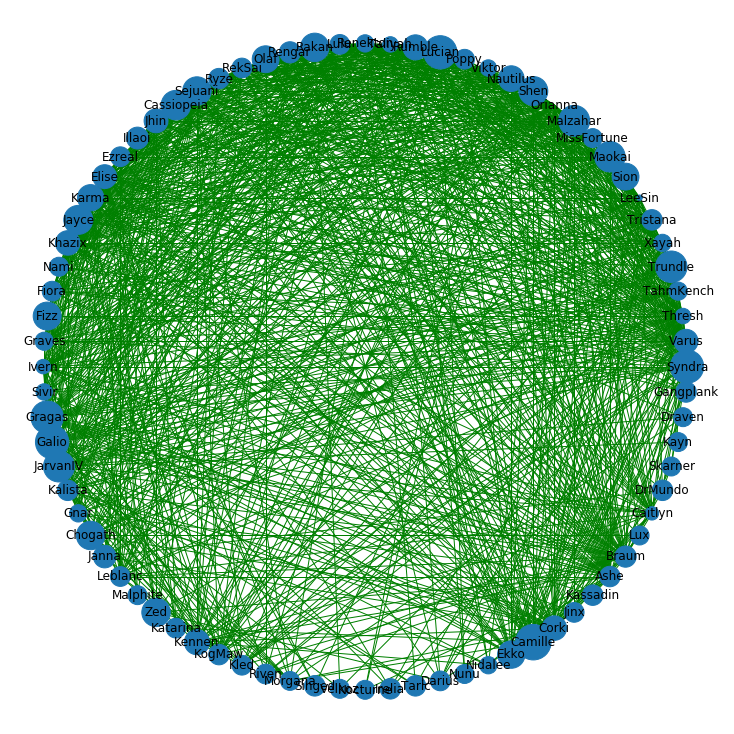

In [42]:
#CBLOL
pos = nx.circular_layout(G_CBLOL)
# larger figure size
plt.figure(3,figsize=(10,10)) 


nx.draw(G_CBLOL,pos,with_labels=True,edge_color='g',node_size =size_from_wins_cblol)
plt.show()

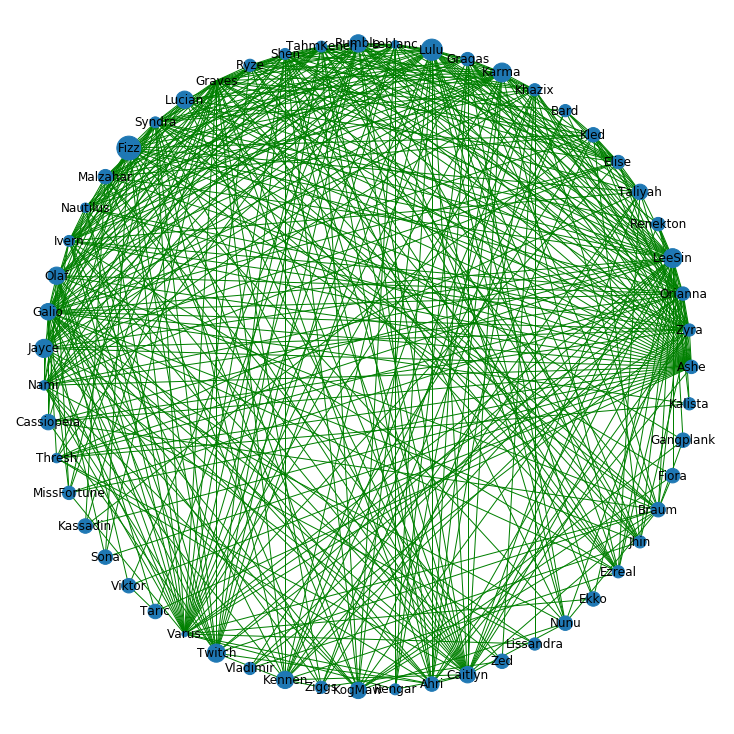

In [43]:
#MSI
pos = nx.circular_layout(G_MSI)
# larger figure size
plt.figure(3,figsize=(10,10)) 


nx.draw(G_MSI,pos,with_labels=True,edge_color='g',node_size =size_from_wins_msi)
plt.show()

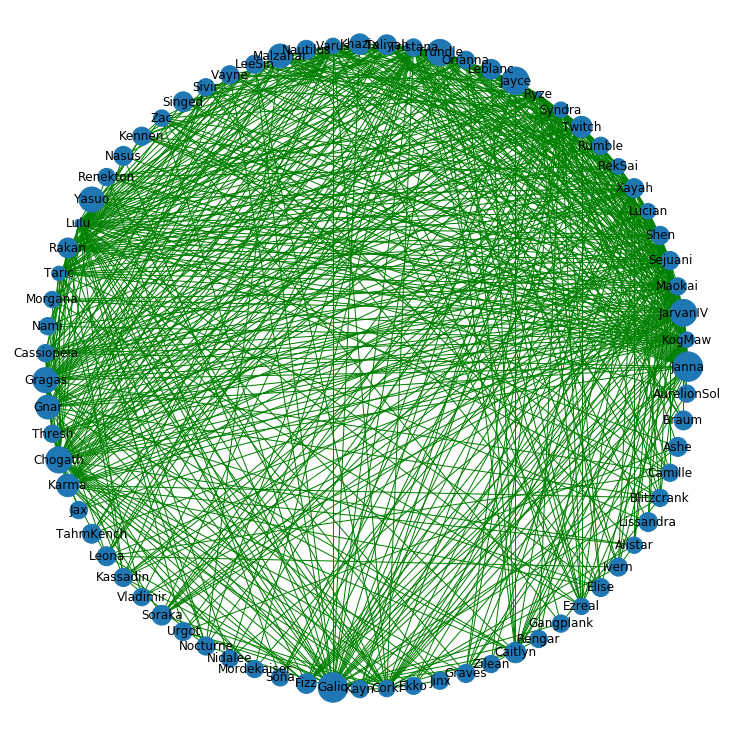

In [44]:
#WC
pos = nx.circular_layout(G_WC)
# larger figure size
plt.figure(3,figsize=(10,10)) 


nx.draw(G_WC,pos,with_labels=True,edge_color='g',node_size =size_from_wins_wc)
plt.show()

In [45]:
!pip install nxviz

     |████████████████████████████████| 225kB 4.2MB/s 
     |████████████████████████████████| 256kB 44.6MB/s 
     |████████████████████████████████| 81kB 20.2MB/s 
     |████████████████████████████████| 17.3MB 44.6MB/s 
     |████████████████████████████████| 1.7MB 36.3MB/s 
     |████████████████████████████████| 276kB 41.7MB/s 
     |████████████████████████████████| 2.3MB 30.1MB/s 
     |████████████████████████████████| 61kB 20.2MB/s 
     |████████████████████████████████| 583kB 32.8MB/s 
     |████████████████████████████████| 102kB 26.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
  Stored in directory: /root/.cache/pip/wheels/74/30/b2/f2da9acb18f37b571f3c17aa03ee6f1ac555514d99d76b9af0
Successfully built networkx PyYAML sphinxcontrib-fulltoc
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you

In [0]:
# Import necessary modules to use Circos plot
import matplotlib.pyplot as plt
from nxviz import CircosPlot 

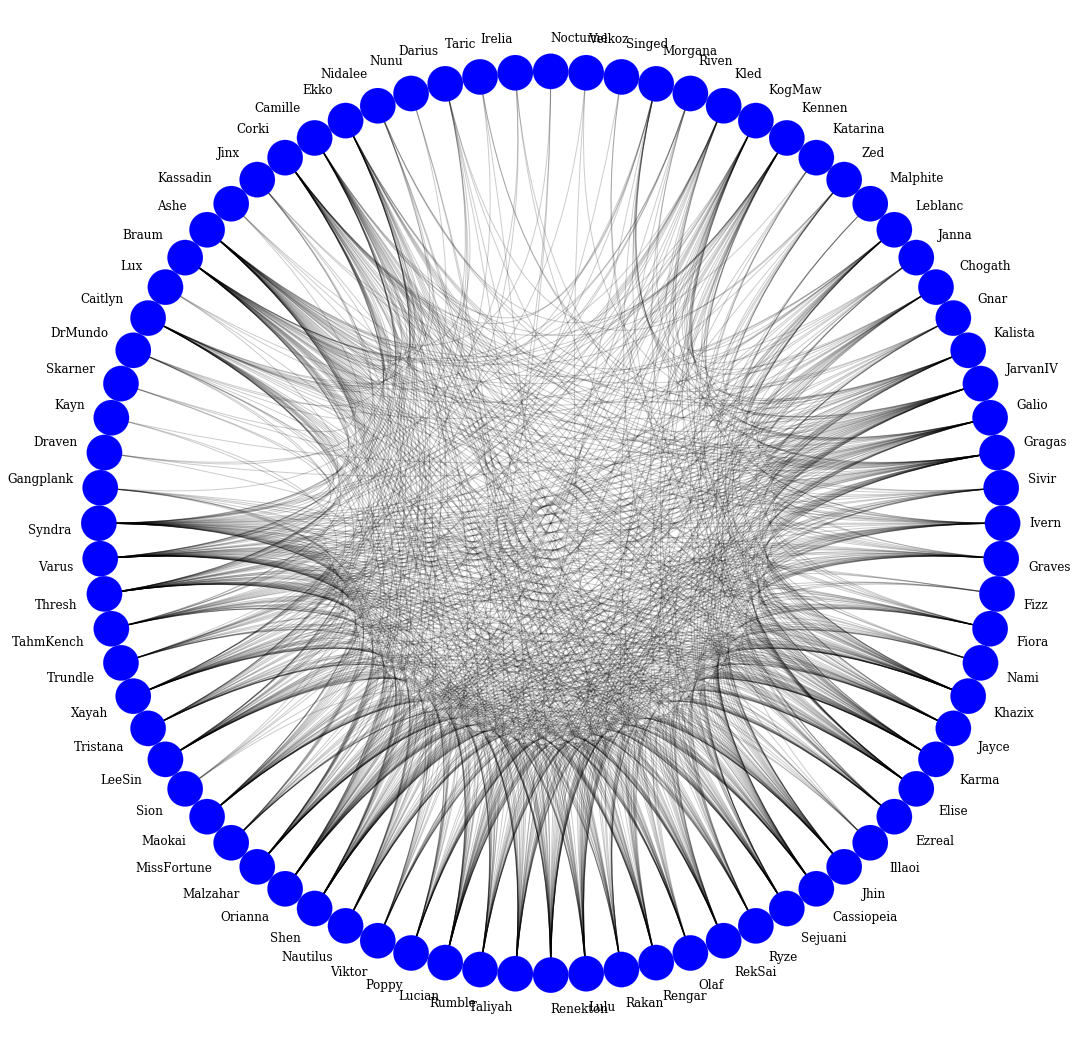

In [47]:
# Create the CircosPlot object - CBLOL
c = CircosPlot(G_CBLOL,
               node_size = size_from_wins_cblol,
               node_labels=True,
               figsize = (15,15),
               nodeprops={"radius": 0.5},
               fontsize=12
               )

# Draw c to the screen
c.draw()
c.figure.tight_layout()

# Display the plot

plt.show()

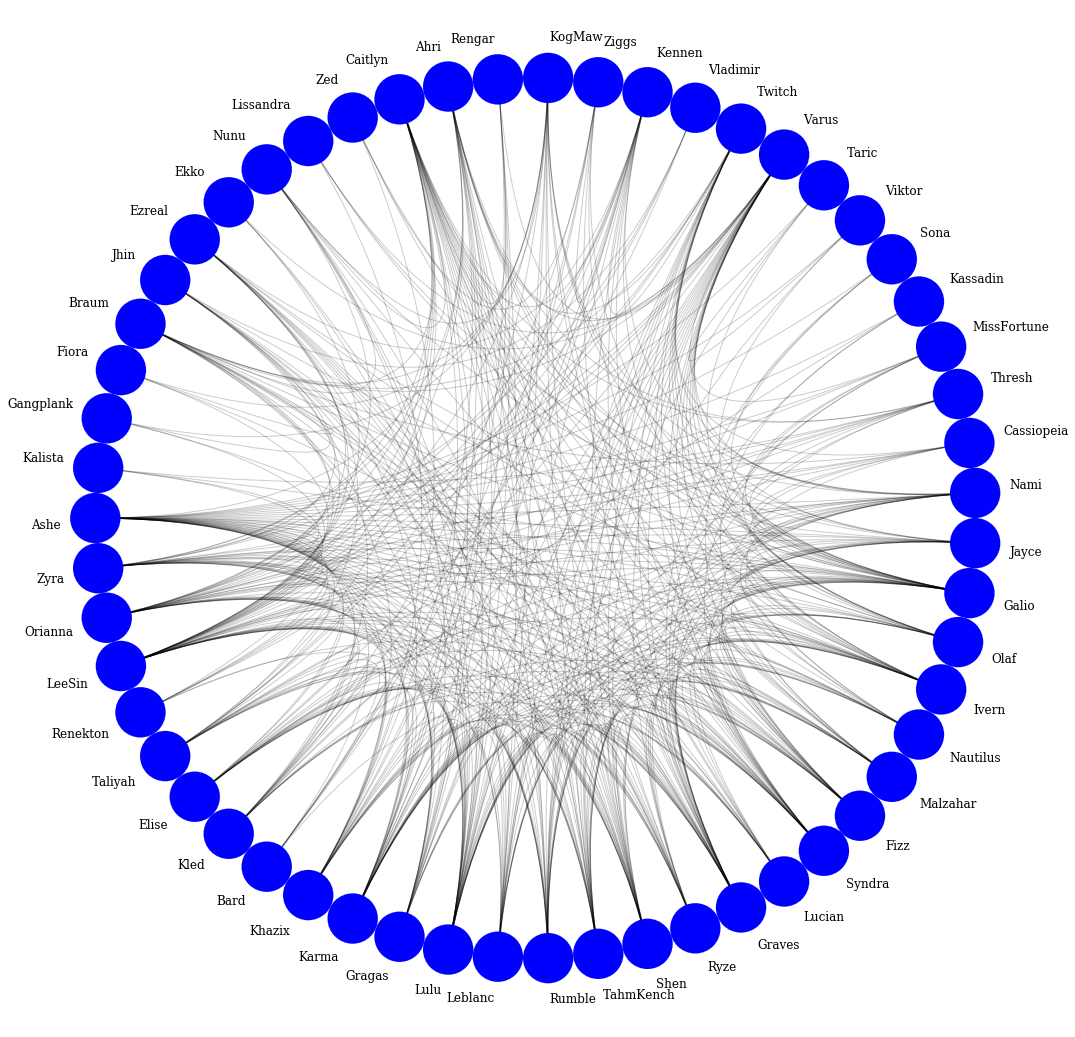

In [48]:
# Create the CircosPlot object - MSI
m = CircosPlot(G_MSI,
               node_size = size_from_wins_msi,
               node_labels=True,
               figsize = (15,15),
               nodeprops={"radius": 0.5},
               fontsize=12
               )

# Draw c to the screen
m.draw()
m.figure.tight_layout()

# Display the plot

plt.show()

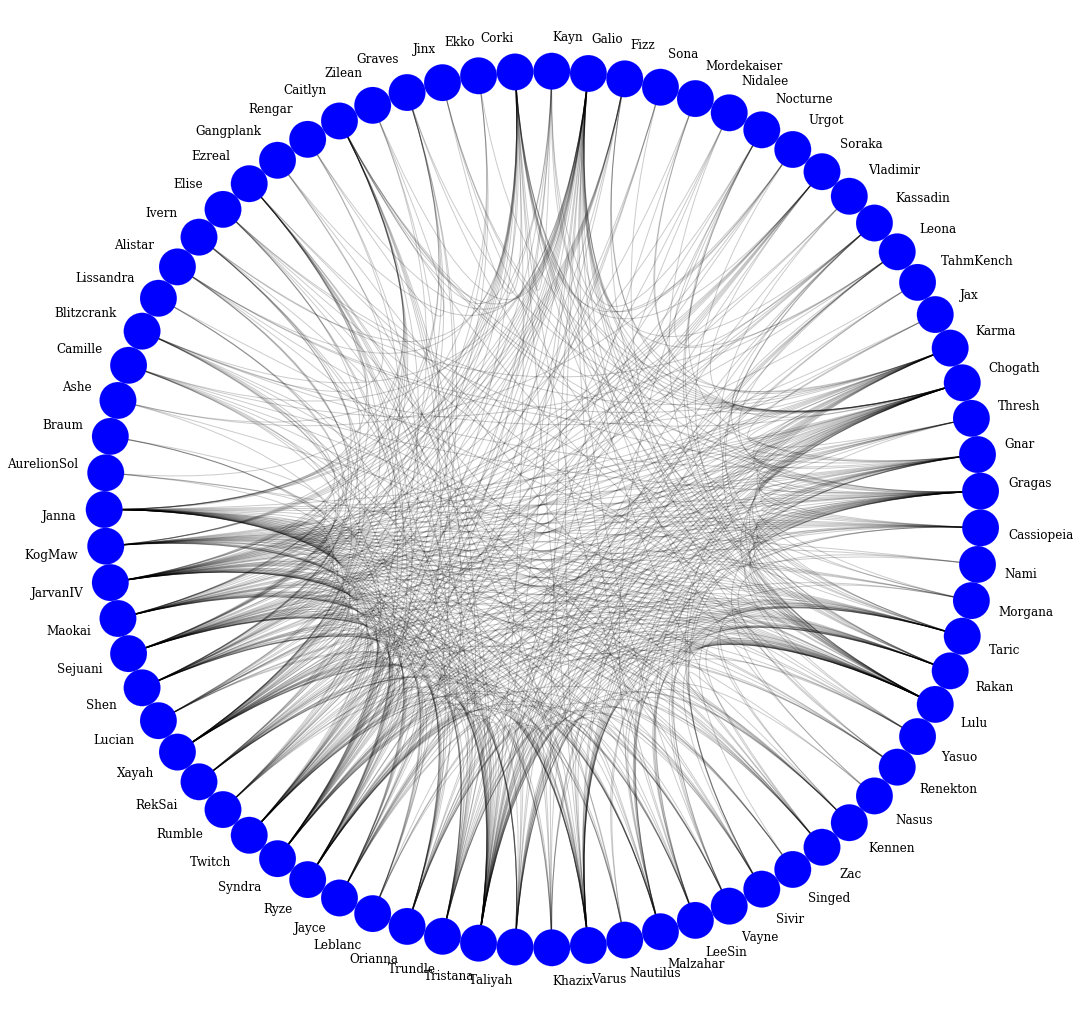

In [49]:
# Create the CircosPlot object - WC
w = CircosPlot(G_WC,
               node_size = size_from_wins_wc,
               node_labels=True,
               figsize = (15,15),
               nodeprops={"radius": 0.5},
               fontsize=12
               )

# Draw c to the screen
w.draw()
w.figure.tight_layout()

# Display the plot

plt.show()

#Criandos Grafos Gephi

A fim de gerar grafos para analise do time perfeito, fizemos usa da ferramenta Gephi, em que configuramos os dados da seguinte forma:


*   Tamanho do Nó: Ranking de acordo com total (de vitorias do champion)
*   Cor do Nó: Partition de acordo com a main_line (line principal do champion)
*   Cor das Arestas: Ranking de acordo com result (peso de vitorias da ligação par a par)
*   Filtro: Intervalo result (arestra) > 0
*   Distribuição: Fruchterman-Reingold







Legenda para saber o significado de cada cor, mas deve-se ignorar as porcentagens nos grafos MSI e WC.

![MSI](https://drive.google.com/uc?authuser=0&id=1dZVxmbCEW-pxY6E0hzYSCBAvHjUbSLap&export=download)

CBLOL

![cblol](https://drive.google.com/uc?authuser=0&id=10SEEJwWYcviOwXhTFjVDH_AzzQOIMU2C&export=download)

MSI

![MSI](https://drive.google.com/uc?authuser=0&id=1y-u6uCp5d4halM4Brw6tFwv-RdKwAmDl&export=download)

WC
![WC](https://drive.google.com/uc?authuser=0&id=1Cl8SUMv2qZd6y1qZFarklN4W3HXjjeqW&export=download)

# Analisando métricas dos jogos

Aqui vamos calcular os campeões mais escolhidos nos campeonatos de 2017

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 

In [51]:
CBLOL.head()

GameID League  Year  Result  ... JungleChamp MiddleChamp ADCChamp SupportChamp
4235  4235b  CBLoL  2017      -1  ...      LeeSin      Syndra     Ashe         Zyra
4236  4236b  CBLoL  2017       1  ...      LeeSin      Xerath     Jhin  MissFortune
4237  4237b  CBLoL  2017       1  ...      LeeSin  Cassiopeia     Ashe         Zyra
4238  4238b  CBLoL  2017       1  ...       Elise      Syndra   Ezreal        Karma
4239  4239b  CBLoL  2017      -1  ...      LeeSin     Orianna     Ashe     Malzahar

[5 rows x 9 columns]

In [52]:
CBLOL["TopChamp"].value_counts().reset_index().head(10)

index  TopChamp
0    Maokai        31
1  Renekton        29
2      Shen        23
3    Rumble        22
4  JarvanIV        21
5  Nautilus        19
6     Poppy        18
7     Fiora        14
8    Gragas        14
9   Camille        10

In [0]:
def make_df_with_pick(df):
    MyEmptydf = pd.DataFrame()
    lines = ["TopChamp","JungleChamp","MiddleChamp","ADCChamp","SupportChamp"]
    for line in lines:
        temp_df = df[line].value_counts().reset_index()
        frame = { line: temp_df["index"], line[:-5]+'Picks': temp_df[line]} 
        frame = pd.DataFrame(frame)
        frame[line[:-5]+'Picks'].apply(int)
        MyEmptydf = pd.concat([MyEmptydf,frame], axis = 1)
    return MyEmptydf
NALCS_TOPS = pd.DataFrame(make_df_with_pick(NALCS))
EULCS_TOPS = pd.DataFrame(make_df_with_pick(EULCS))
WC_TOPS = pd.DataFrame(make_df_with_pick(WC))
CBLOL_TOPS = pd.DataFrame(make_df_with_pick(CBLOL))
MSI_TOPS = pd.DataFrame(make_df_with_pick(MSI))
LCK_TOPS = pd.DataFrame(make_df_with_pick(LCK))


In [54]:
CBLOL_TOPS.head()

TopChamp  TopPicks JungleChamp  ...  ADCPicks SupportChamp  SupportPicks
0    Maokai        31      Khazix  ...      58.0        Karma          47.0
1  Renekton        29      LeeSin  ...      41.0       Thresh          33.0
2      Shen        23       Elise  ...      38.0        Braum          32.0
3    Rumble        22      RekSai  ...      23.0         Zyra          24.0
4  JarvanIV        21      Gragas  ...      20.0     Malzahar          24.0

[5 rows x 10 columns]

Lista com imagens dos campeõs mais escolhidos

In [55]:
def picks(df,league):
    print("")
    print(league.upper())
    print("")
    lines = ["TopChamp","JungleChamp","MiddleChamp","ADCChamp","SupportChamp"]
    for line in lines:
        print("")
        print(line.upper())
        print("")
        for index, row in df.head().iterrows():
            display(Image(url= "https://ddragon.leagueoflegends.com/cdn/9.12.1/img/champion/"+row[line]+".png", width=60, height=60))
            print(str(row[line]))
            print("PICKS: " + str(row[line[:-5]+"Picks"]))
    display()
picks(NALCS_TOPS,"NALCS 2017")
picks(EULCS_TOPS,"EULCS 2017")
picks(WC_TOPS,"WC 2017")
picks(CBLOL_TOPS,"CBLOL 2017")
picks(MSI_TOPS,"MSI 2017")
picks(LCK_TOPS,"LCK 2017")


NALCS 2017


TOPCHAMP



Shen
PICKS: 130.0


Maokai
PICKS: 121.0


Nautilus
PICKS: 112.0


Renekton
PICKS: 109.0


Rumble
PICKS: 99.0

JUNGLECHAMP



Khazix
PICKS: 148.0


LeeSin
PICKS: 139.0


Gragas
PICKS: 127.0


Elise
PICKS: 125.0


Rengar
PICKS: 110.0

MIDDLECHAMP



Orianna
PICKS: 181


Corki
PICKS: 121


Taliyah
PICKS: 112


Syndra
PICKS: 110


Cassiopeia
PICKS: 85

ADCCHAMP



Varus
PICKS: 183.0


Ashe
PICKS: 173.0


Jhin
PICKS: 164.0


Caitlyn
PICKS: 103.0


Tristana
PICKS: 79.0

SUPPORTCHAMP



Karma
PICKS: 161.0


Thresh
PICKS: 141.0


Lulu
PICKS: 123.0


Zyra
PICKS: 103.0


Braum
PICKS: 81.0

EULCS 2017


TOPCHAMP



Rumble
PICKS: 110.0


Shen
PICKS: 102.0


Gnar
PICKS: 74.0


Renekton
PICKS: 64.0


Maokai
PICKS: 53.0

JUNGLECHAMP



Khazix
PICKS: 110.0


Gragas
PICKS: 97.0


LeeSin
PICKS: 96.0


Graves
PICKS: 82.0


Elise
PICKS: 78.0

MIDDLECHAMP



Syndra
PICKS: 118


Orianna
PICKS: 108


Corki
PICKS: 64


Cassiopeia
PICKS: 60


Ryze
PICKS: 60

ADCCHAMP



Varus
PICKS: 130.0


Ashe
PICKS: 109.0


Jhin
PICKS: 106.0


Caitlyn
PICKS: 73.0


Xayah
PICKS: 61.0

SUPPORTCHAMP



Thresh
PICKS: 103.0


Braum
PICKS: 85.0


TahmKench
PICKS: 77.0


Karma
PICKS: 75.0


Zyra
PICKS: 74.0

WC 2017


TOPCHAMP



Chogath
PICKS: 40


Maokai
PICKS: 25


Shen
PICKS: 22


Gnar
PICKS: 16


Trundle
PICKS: 10

JUNGLECHAMP



Sejuani
PICKS: 44.0


JarvanIV
PICKS: 37.0


Gragas
PICKS: 36.0


RekSai
PICKS: 11.0


Ezreal
PICKS: 6.0

MIDDLECHAMP



Ryze
PICKS: 28.0


Syndra
PICKS: 23.0


Galio
PICKS: 17.0


Taliyah
PICKS: 16.0


Corki
PICKS: 16.0

ADCCHAMP



Tristana
PICKS: 45.0


KogMaw
PICKS: 27.0


Xayah
PICKS: 25.0


Varus
PICKS: 23.0


Twitch
PICKS: 22.0

SUPPORTCHAMP



Lulu
PICKS: 47.0


Janna
PICKS: 44.0


Rakan
PICKS: 20.0


Taric
PICKS: 18.0


Karma
PICKS: 8.0

CBLOL 2017


TOPCHAMP



Maokai
PICKS: 31


Renekton
PICKS: 29


Shen
PICKS: 23


Rumble
PICKS: 22


JarvanIV
PICKS: 21

JUNGLECHAMP



Khazix
PICKS: 47.0


LeeSin
PICKS: 36.0


Elise
PICKS: 34.0


RekSai
PICKS: 24.0


Gragas
PICKS: 19.0

MIDDLECHAMP



Syndra
PICKS: 44.0


Orianna
PICKS: 41.0


Cassiopeia
PICKS: 30.0


Corki
PICKS: 21.0


Taliyah
PICKS: 19.0

ADCCHAMP



Varus
PICKS: 58.0


Ashe
PICKS: 41.0


Jhin
PICKS: 38.0


Xayah
PICKS: 23.0


Ezreal
PICKS: 20.0

SUPPORTCHAMP



Karma
PICKS: 47.0


Thresh
PICKS: 33.0


Braum
PICKS: 32.0


Zyra
PICKS: 24.0


Malzahar
PICKS: 24.0

MSI 2017


TOPCHAMP



Galio
PICKS: 18.0


Shen
PICKS: 14.0


Rumble
PICKS: 14.0


Gragas
PICKS: 8.0


Nautilus
PICKS: 7.0

JUNGLECHAMP



Graves
PICKS: 24.0


LeeSin
PICKS: 24.0


Ivern
PICKS: 10.0


Khazix
PICKS: 9.0


Olaf
PICKS: 6.0

MIDDLECHAMP



Syndra
PICKS: 14


Orianna
PICKS: 14


Leblanc
PICKS: 10


Taliyah
PICKS: 8


Ryze
PICKS: 7

ADCCHAMP



Ashe
PICKS: 24.0


Varus
PICKS: 15.0


Caitlyn
PICKS: 13.0


Twitch
PICKS: 11.0


KogMaw
PICKS: 7.0

SUPPORTCHAMP



Karma
PICKS: 16.0


Lulu
PICKS: 15.0


TahmKench
PICKS: 14.0


Zyra
PICKS: 9.0


Nami
PICKS: 7.0

LCK 2017


TOPCHAMP



Maokai
PICKS: 124


Rumble
PICKS: 100


Shen
PICKS: 94


Nautilus
PICKS: 89


Renekton
PICKS: 86

JUNGLECHAMP



Elise
PICKS: 168.0


LeeSin
PICKS: 142.0


Graves
PICKS: 128.0


Khazix
PICKS: 127.0


Gragas
PICKS: 109.0

MIDDLECHAMP



Taliyah
PICKS: 134.0


Orianna
PICKS: 131.0


Corki
PICKS: 117.0


Syndra
PICKS: 94.0


Cassiopeia
PICKS: 69.0

ADCCHAMP



Ashe
PICKS: 214.0


Varus
PICKS: 156.0


Jhin
PICKS: 133.0


Xayah
PICKS: 91.0


Caitlyn
PICKS: 89.0

SUPPORTCHAMP



Karma
PICKS: 132.0


Zyra
PICKS: 127.0


Thresh
PICKS: 125.0


Braum
PICKS: 107.0


Lulu
PICKS: 102.0
